In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

from random import shuffle
import pandas as pd

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [4]:
# have a look at the first example
print(raw_training_data[0])
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
9775 instances
99491 words


In [5]:
def preProcess_one(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [6]:
training_data_one = [preProcess_one(example) for example in raw_training_data]

In [7]:
# check the effect of pre-processing
print(training_data_one[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


# 1. Split the training data into 80% training, 20% development set

 <B> 1. THE INPUT DATA IS SPLIT INTO TWO: 80% TRAINING AND 20% DEVELOPMENT SET </BR>
 <B> 2. NO SHUFFLING PERFORMED DURING SPLITTING

In [8]:
testData_one = []
trainData_one = []
length = len(training_data_one)
split_percentage = 0.8
split = int(length*split_percentage)
trainData_one = training_data_one[0:split]
testData_one = training_data_one[split:]

 <B> 3. SAMPLE CONTENT OF TRAINING DATA AND DEVELOPMENT DATA:

In [9]:
print(trainData_one[0])
print(testData_one[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('what', 'O'), ('five', 'B-RATINGS_AVERAGE'), ('star', 'O'), ('rated', 'O'), ('thriller', 'B-GENRE'), ('directed', 'O'), ('by', 'O'), ('dover', 'B-DIRECTOR'), ('koshashvili', 'I-DIRECTOR'), ('is', 'O'), ('unrated', 'B-RATING')]


 <B> 4. FEATURE FUNCTION: - IT COVERS THE BASICS FEATURES (WILL BE UPDATED LATER)

In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_one(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUFFIX_01_" + token[-1:])
        feature_list.append("PREFIX_01_" + token[0:1])
    if len(token) > 2:
        feature_list.append("SUFFIX_02_" + token[-2:])
        feature_list.append("PREFIX_02_" + token[0:2])
    if len(token) > 3:
        feature_list.append("SUFFIX_03_" + token[-3:])
        feature_list.append("PREFIX_03_" + token[0:3])
    if len(token) > 4:
        feature_list.append("SUFFIX_04_" + token[-4:])
        feature_list.append("PREFIX_04_" + token[0:4])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

 <B> 5. TRAINING

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_one)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data_one, TAGGER_PATH)
print("done")


training tagger...
done


 <B> 6. TESTING

In [12]:
print("testing tagger...")
preds = []
y_test = []
for sent in testData_one:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


 <B> 7. STORING THE CLASSIFICATION REPORT

In [13]:
dev_data_only = classification_report(y_test, preds)

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 <B> 8. GENERATING CONFUSION MATRIX HEAT MAP

In [14]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-TITLE', 'B-TRAILER', 'I-YEAR', 'I-REVIEW', 'I-DIRECTOR', 'B-CHARACTER', 'I-GENRE', 'I-RATING', 'I-TRAILER', 'O', 'B-GENRE', 'B-DIRECTOR', 'B-RATING', 'B-SONG', 'B-RATINGS_AVERAGE', 'I-PLOT', 'B-YEAR', 'B-ACTOR', 'I-SONG', 'I-RATINGS_AVERAGE', 'I-CHARACTER', 'B-REVIEW', 'I-TITLE', 'I-ACTOR', 'B-PLOT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


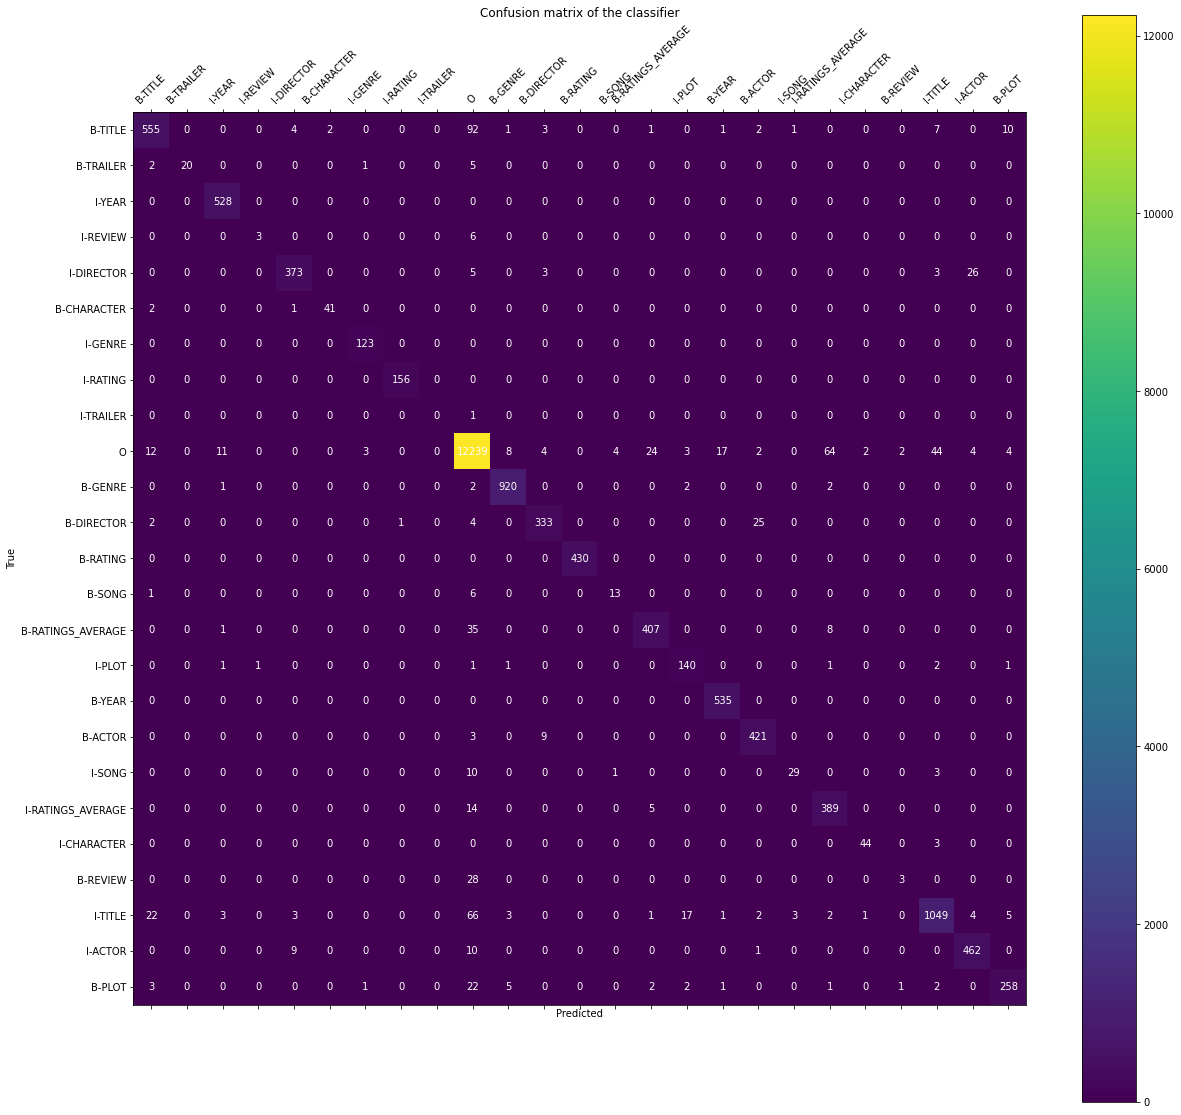

In [15]:
confusion_matrix_heatmap(y_test, preds)

# 2. Error analysis 1: False positives

1. IDENTIFYING THE 5 CLASSES WHICH HAS THE LOWEST PRECISION </BR>
2. THE <B>preds</B> AND <B>y_test</B> HAS THE PREDICTED AND TRUE VALUES </BR>
3. THE CLASSIFICATION REPORT IS USED TO GATHER THE INFORMATION ABOUT THE LOWEST PRECISION AND LOWEST RECALL </BR>
4. THE POP FUNCTION IS USED TO REMOVE THE ACCURACY, MACRO AVG, AND WEIGHTED AVG FROM THE DICTIONARY CREATED BY CLASSIFICATION REPORT </BR>
5. THEN THE PRECISION AND RECALL ARE GATHERED IN VARIABLES IN A SORTED WAY USING SORTING FUNCTION </BR>
6. USING A FOR LOOP THE LOWEST PRECISION AND RECALL IS APPENDED TO A LIST
7. THUS THE LOWEST PRECISIONS ARE IDENTIFIED AND STORED DYNAMICALLY IN THE VARIALBE <B>lowest_precision</B>
8. SIMILARY THE LOWEST RECALL STORED IN THE VARIABLE <B>lowest_recall</B>
9. FINALLY FOR EVERY <B>"sent_preds != sent_true"</B> THE FALSE POSITIVES AND FALSE NEGATIVES ARE GROUPED TOGETHER
10.  THE OUTPUT IS GENERATED IN THE FORMAT: </BR>
<B>"[TRUTH: O ] [ PREDICTED: I-RATINGS_AVERAGE ] [ WORD: ('star', 'O') ] [ SENTENCE: what five star rated thriller directed by dover koshashvili is unrated" </B>

In [16]:
print("testing tagger...")
print('\n')
preds = []
y_test = []

for sent in testData_one:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

#checked
#print("Preds:",sorted(set(preds)))
#print("Test:", sorted(set(y_test)))

dictionary = classification_report(y_test, preds,output_dict = True)

dictionary.pop("accuracy")
dictionary.pop("macro avg")
dictionary.pop("weighted avg")

precision = sorted(dictionary.items(), key=lambda x: x[1]['precision'])
recall = sorted(dictionary.items(), key=lambda x: x[1]['recall'])

#checked
#print(precision[0:5]) 
#print(recall[0:5])

lowest_precision = []
lowest_recall = []

for p in precision[0:5]:
    lowest_precision.append(p[0])    

for r in recall[0:5]:
    lowest_recall.append(r[0])  
    
#checked
#print(test_data)

FP = []
FN = []
for sent in testData_one:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    if sent_preds != sent_true:
        for p, t, s in zip(sent_preds, sent_true, sent):
            if p != t:
                if p in lowest_precision:
                    sentence = ' '.join([s[0] for s in sent])
                    FP.append((t, p, s, sentence))
                if t in lowest_recall: 
                    sentence = ' '.join([s[0] for s in sent])
                    FN.append((t, p, s, sentence))

testing tagger...




In [17]:
print("Lowest precision found in the following:", lowest_precision)

print('\n')
print("------------------------------")
print(len(FP), "False Positives:")
print("------------------------------")
for fp in FP:
    print("[ TRUTH:",fp[0],"] [ PREDICTED:",fp[1], "] [ WORD:",fp[2],"] [ SENTENCE:",fp[3],"]")

Lowest precision found in the following: ['I-TRAILER', 'B-REVIEW', 'B-SONG', 'I-REVIEW', 'I-RATINGS_AVERAGE']


------------------------------
87 False Positives:
------------------------------
[ TRUTH: O ] [ PREDICTED: I-RATINGS_AVERAGE ] [ WORD: ('star', 'O') ] [ SENTENCE: what five star rated thriller directed by dover koshashvili is unrated ]
[ TRUTH: O ] [ PREDICTED: I-RATINGS_AVERAGE ] [ WORD: ('rated', 'O') ] [ SENTENCE: what five star rated thriller directed by dover koshashvili is unrated ]
[ TRUTH: O ] [ PREDICTED: I-RATINGS_AVERAGE ] [ WORD: ('star', 'O') ] [ SENTENCE: what five star rating movie did jamie luner act in ]
[ TRUTH: O ] [ PREDICTED: I-RATINGS_AVERAGE ] [ WORD: ('rated', 'O') ] [ SENTENCE: what four star rated horror movie was directed by fritz kiersch ]
[ TRUTH: O ] [ PREDICTED: I-RATINGS_AVERAGE ] [ WORD: ('ratings', 'O') ] [ SENTENCE: what horror movie that came out in 1980 and had decent ratings and was directed by shane thueson ]
[ TRUTH: O ] [ PREDICTED: I

# 3. Error analysis 2: False negatives

THE STEPS ARE MENTIONED AS ABOVE </BR>
THE OUTPUT IS GENERATED IN THE FORMAT: </BR>
<B> [ TRUTH: B-REVIEW ] [ PREDICTED: O ] [ WORD: ('reviews', 'B-REVIEW') ] [ SENTENCE: can you show me some reviews for purple rain ]</B>


In [18]:
print("Lowest recall found in the following:", lowest_recall)

print('\n')
print("------------------------------")
print(len(FN), "False Negatives:")
print("------------------------------")
for fn in FN:
    print("[ TRUTH:",fn[0],"] [ PREDICTED:",fn[1], "] [ WORD:",fn[2],"] [ SENTENCE:",fn[3],"]")
    
print("done")

Lowest recall found in the following: ['I-TRAILER', 'B-REVIEW', 'I-REVIEW', 'B-SONG', 'I-SONG']


------------------------------
56 False Negatives:
------------------------------
[ TRUTH: B-REVIEW ] [ PREDICTED: O ] [ WORD: ('reviews', 'B-REVIEW') ] [ SENTENCE: can you show me some reviews for purple rain ]
[ TRUTH: B-REVIEW ] [ PREDICTED: O ] [ WORD: ('reviews', 'B-REVIEW') ] [ SENTENCE: where can i find good reviews about the movie purple rain ]
[ TRUTH: B-REVIEW ] [ PREDICTED: O ] [ WORD: ('reviews', 'B-REVIEW') ] [ SENTENCE: could you show me a website with detailed reviews of purple rain ]
[ TRUTH: B-REVIEW ] [ PREDICTED: O ] [ WORD: ('reviews', 'B-REVIEW') ] [ SENTENCE: can you let me know what reviews people of my age group gave for purple rain ]
[ TRUTH: B-REVIEW ] [ PREDICTED: O ] [ WORD: ('reviews', 'B-REVIEW') ] [ SENTENCE: what were the reviews like for purple rain ]
[ TRUTH: B-REVIEW ] [ PREDICTED: O ] [ WORD: ('opinions', 'B-REVIEW') ] [ SENTENCE: where can i find detail

# 4. Using POS tags as features

<B> 1. USING THE PROVIDED CODE SNIPPET THE PREPROCESS IS UPDATED </BR>
<B> 2. THE WORD AND POS TAG ARE CONCATENATED TOGETHER  USING "/" AND PUT BACK TOGETHER WITH THE BIO TAG IN THE PREPROCESS FUNCTION </B>

In [19]:
def preProcess_two(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    #print(example)
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    wordCRF = [x[0]+'/'+x[1] for x in posttagger.tag([s[0] for s in example])]
    BIO = [s[1] for s in example]  
    preprocessed_example = [[x,y] for x,y in zip(wordCRF,BIO)]
    return preprocessed_example

<B> 3. THE PREPROCESS FUNCTION IS CALLED UPON THE TRAINING DATA SET </BR>
<B> 4. THE PREPROCESS IS PERFORMED BEFORE SPLITTING OF DATA AS TRAINING AND DEVELOPMENT SET </B>

In [20]:
training_data_two = [preProcess_two(example) for example in raw_training_data]

<B> 5. SAMPLE CONTENT OF THE PREPROCESSED TRAINING DATA: </B>

In [21]:
print(training_data_two[0])

[['what/WP', 'O'], ['movies/VBZ', 'O'], ['star/NNP', 'O'], ['bruce/NNP', 'B-ACTOR'], ['willis/NNP', 'I-ACTOR']]


<B> 6. THE DATASET SPLIT INTO TRAINING AND DEVELOPMENT DATASET </B>

In [22]:
testData_two = []
trainData_two = []
length = len(training_data_two)
split_percentage = 0.8
split = int(length*split_percentage)
trainData_two = training_data_two[0:split]
testData_two = training_data_two[split:]

<B> 7. SAMPLE SPLIT DATA CONTENTS:

In [23]:
print(trainData_two[0])
print(testData_two[0])

[['what/WP', 'O'], ['movies/VBZ', 'O'], ['star/NNP', 'O'], ['bruce/NNP', 'B-ACTOR'], ['willis/NNP', 'I-ACTOR']]
[['what/WP', 'O'], ['five/CD', 'B-RATINGS_AVERAGE'], ['star/GW', 'O'], ['rated/^JJ', 'O'], ['thriller/NN', 'B-GENRE'], ['directed/VBN', 'O'], ['by/IN', 'O'], ['dover/NNP', 'B-DIRECTOR'], ['koshashvili/NNP', 'I-DIRECTOR'], ['is/VBZ', 'O'], ['unrated/VBN', 'B-RATING']]


<B> 8. THE GET FEATURE FUNCTION UPATED TO ADD THE POS TAG AS A FEATURE: </BR>
<B> 9. THE INPUT TOKENS ARE SPLIT INTO THE TOKEN AND POS TAG AND APPENDED TO THE FEATURE LIST

In [24]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_two(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    #print(token)
    feature_list = []
    token_POS_split = token.split("/")
    token = token_POS_split[0]
    
    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUFFIX_01_" + token[-1:])
        feature_list.append("PREFIX_01_" + token[0:1])
    if len(token) > 2:
        feature_list.append("SUFFIX_02_" + token[-2:])
        feature_list.append("PREFIX_02_" + token[0:2])
    if len(token) > 3:
        feature_list.append("SUFFIX_03_" + token[-3:])
        feature_list.append("PREFIX_03_" + token[0:3])
    if len(token) > 4:
        feature_list.append("SUFFIX_04_" + token[-4:])
        feature_list.append("PREFIX_04_" + token[0:4])
        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + token_POS_split[1])


    #print(feature_list)
    return feature_list

<B> 10. TRAINING

In [25]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_two)  # initialize tagger with get_features function

print("training tagger...")
ct.train(trainData_two, TAGGER_PATH)
print("done")
#print(test_data)

training tagger...
done


<B> 11. TESTING

In [26]:
print("testing tagger...")
print('\n')
preds = []
y_test = []

for sent in testData_two:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
#checked
#print("Preds:",sorted(set(preds)))
#print("Test:", sorted(set(y_test)))   
print("done")

testing tagger...


done


<B>12. STORING THE CLASSIFICATION REPORT

In [27]:
# Output the classification report (which you should save each time for comparing your models)
suf_pos_only = classification_report(y_test, preds)

# 5. Feature experimentation for optimal macro average

<B> 1. ADJUSTING THE FEATURE FUNCTION </BR>
<B> 2. THE FOLLOWING IS TESTED BY ADDING ONLY THE NEXTWORD </BR>

In [28]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_three(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    token_POS_split = token.split("/")
    token = token_POS_split[0]
    bio = token_POS_split[1]
    
    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUFFIX_01_" + token[-1:])
        feature_list.append("PREFIX_01_" + token[0:1])
    if len(token) > 2:
        feature_list.append("SUFFIX_02_" + token[-2:])
        feature_list.append("PREFIX_02_" + token[0:2])
    if len(token) > 3:
        feature_list.append("SUFFIX_03_" + token[-3:])
        feature_list.append("PREFIX_03_" + token[0:3])
    if len(token) > 4:
        feature_list.append("SUFFIX_04_" + token[-4:])
        feature_list.append("PREFIX_04_" + token[0:4]) 
        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + bio)

    regrp = []
    for x in tokens:
        regrp.append(tuple(x.split("/")))
    regrp1=(list(zip(*regrp)))
    
    if idx < len(regrp1[1]) -1 :
        feature_list.append("NEXTWORD_" +regrp1[0][idx+1])     
        
    if(idx==0):
        feature_list.append("START_OF_SENT")
    
    if(idx == len(regrp1[1]) -1):
        feature_list.append("END_OF_SENT")
    
    #print(feature_list)
    return feature_list

<B> 3.TRAINING

In [29]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_three)  # initialize tagger with get_features function

print("training tagger...")
ct.train(trainData_two, TAGGER_PATH)
print("done")
#print(test_data)

training tagger...
done


<B> 4.TESTING

In [30]:
print("testing tagger...")
preds = []
y_test = []
for sent in testData_two:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


<B> 5. STORING THE CLASSIFICATION REPORT

In [31]:
nextword_only = classification_report(y_test, preds)

<B> 6. THE FOLLOWING IS TESTED BY ADDING NEXT WORD AND PREVIOUS WORD

In [32]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_four(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    token_POS_split = token.split("/")
    token = token_POS_split[0]
    bio = token_POS_split[1]
    
    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")
        
    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUFFIX_01_" + token[-1:])
        feature_list.append("PREFIX_01_" + token[0:1])
    if len(token) > 2:
        feature_list.append("SUFFIX_02_" + token[-2:])
        feature_list.append("PREFIX_02_" + token[0:2])
    if len(token) > 3:
        feature_list.append("SUFFIX_03_" + token[-3:])
        feature_list.append("PREFIX_03_" + token[0:3])
    if len(token) > 4:
        feature_list.append("SUFFIX_04_" + token[-4:])
        feature_list.append("PREFIX_04_" + token[0:4]) 
        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + bio)
    
    regrp = []
    for x in tokens:
        regrp.append(tuple(x.split("/")))
    regrp1=(list(zip(*regrp)))
    
    if idx < len(regrp1[1]) -1 :
        feature_list.append("NEXTWORD_" +regrp1[0][idx+1])
    
    if (idx > 0) and (idx < len(regrp1[1])):
        feature_list.append("PREWORD_" +regrp1[0][idx-1])        
    
    if(idx==0):
        feature_list.append("START_OF_SENT")
    
    if(idx == len(regrp1[1]) -1):
        feature_list.append("END_OF_SENT")
        
    #print(feature_list)
    return feature_list

<B> 7. TRAINING

In [33]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_four)  # initialize tagger with get_features function

print("training tagger...")
ct.train(trainData_two, TAGGER_PATH)
print("done")
#print(test_data)

training tagger...
done


<B> 8. TESTING

In [34]:
print("testing tagger...")
preds = []
y_test = []
for sent in testData_two:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


<B> 9. STORING THE CLASSIFICATION REPORT

In [35]:
allwords_only = classification_report(y_test, preds)

<B>10. THE FOLLOWING IS TESTED BY ADDING PREVIOUS TAG

In [36]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_five(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    token_POS_split = token.split("/")
    token = token_POS_split[0]
    bio = token_POS_split[1]
    
    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")
        
    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUFFIX_01_" + token[-1:])
        feature_list.append("PREFIX_01_" + token[0:1])
    if len(token) > 2:
        feature_list.append("SUFFIX_02_" + token[-2:])
        feature_list.append("PREFIX_02_" + token[0:2])
    if len(token) > 3:
        feature_list.append("SUFFIX_03_" + token[-3:])
        feature_list.append("PREFIX_03_" + token[0:3])
    if len(token) > 4:
        feature_list.append("SUFFIX_04_" + token[-4:])
        feature_list.append("PREFIX_04_" + token[0:4]) 
        
    regrp = []
    for x in tokens:
        regrp.append(tuple(x.split("/")))
    regrp1=(list(zip(*regrp)))
     
   
    if (idx > 0) and (idx < len(regrp1[1])):
        feature_list.append("PRETAG_" +regrp1[1][idx-1] )
    
    if(idx==0):
        feature_list.append("START_OF_SENT")
    
    if(idx == len(regrp1[1]) -1):
        feature_list.append("END_OF_SENT")
        
    #print(feature_list)
    return feature_list

<B> 11. TRAINING

In [37]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_five)  # initialize tagger with get_features function

print("training tagger...")
ct.train(trainData_two, TAGGER_PATH)
print("done")
#print(test_data)

training tagger...
done


<B> 12. TESTING

In [38]:
print("testing tagger...")
preds = []
y_test = []
for sent in testData_two:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


<B> 13. STORING THE CLASSIFICATION REPORT

In [39]:
prev_tags_only = classification_report(y_test, preds)

<B>14. THE FOLLOWING IS TESTED BY ADDING BOTH TAGS AND BOTH WORDS

In [40]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_six(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    token_POS_split = token.split("/")
    token = token_POS_split[0]
    bio = token_POS_split[1]
    
    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")
        
    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUFFIX_01_" + token[-1:])
        feature_list.append("PREFIX_01_" + token[0:1])
    if len(token) > 2:
        feature_list.append("SUFFIX_02_" + token[-2:])
        feature_list.append("PREFIX_02_" + token[0:2])
    if len(token) > 3:
        feature_list.append("SUFFIX_03_" + token[-3:])
        feature_list.append("PREFIX_03_" + token[0:3])
    if len(token) > 4:
        feature_list.append("SUFFIX_04_" + token[-4:])
        feature_list.append("PREFIX_04_" + token[0:4])         

       
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + bio)
    
    regrp = []
    for x in tokens:
        regrp.append(tuple(x.split("/")))
    regrp1=(list(zip(*regrp)))
    
    if idx < len(regrp1[1]) -1 :
        feature_list.append("NEXTTAG_" +regrp1[1][idx+1])
        feature_list.append("NEXTWORD_" +regrp1[0][idx+1])
        
    
    if (idx > 0) and (idx < len(regrp1[1])):
        feature_list.append("PRETAG_" +regrp1[1][idx-1] )
        feature_list.append("PREWORD_" +regrp1[0][idx-1])        
    
    if(idx==0):
        feature_list.append("START_OF_SENT")
    
    if(idx == len(regrp1[1]) -1):
        feature_list.append("END_OF_SENT")
        
    #print(feature_list)
    return feature_list

<B> 15. TRAINING

In [41]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_six) # initialize tagger with get_features function

print("training tagger...")
ct.train(trainData_two, TAGGER_PATH)
print("done")

training tagger...
done


<B> 16. TESTING

In [42]:
print("testing tagger...")
preds = []
y_test = []
for sent in testData_two:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


<B> 17. STORING THE CLASSIFICATION REPORT

In [43]:
words_tags = classification_report(y_test, preds)

<B> 16. TRAINING ON THE WHOLE TRAINING DATASET "engtrain.bio.txt"

In [44]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_six)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data_two, TAGGER_PATH)
print("done")

training tagger...
done


<B> 17. TESTING ON THE TEST DATA SET "engtest.bio.txt"

In [45]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features_six)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess_two(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [46]:
print("testing tagger...")
preds = []
y_test = []

for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

print("done")

testing tagger...
done


In [47]:
final = classification_report(y_test, preds)

In [49]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-TITLE', 'B-TRAILER', 'I-YEAR', 'I-REVIEW', 'I-DIRECTOR', 'B-CHARACTER', 'I-RATING', 'I-GENRE', 'I-TRAILER', 'O', 'B-GENRE', 'B-DIRECTOR', 'B-SONG', 'B-RATING', 'B-RATINGS_AVERAGE', 'I-PLOT', 'B-YEAR', 'B-ACTOR', 'I-SONG', 'I-RATINGS_AVERAGE', 'I-CHARACTER', 'B-REVIEW', 'I-TITLE', 'I-ACTOR', 'B-PLOT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


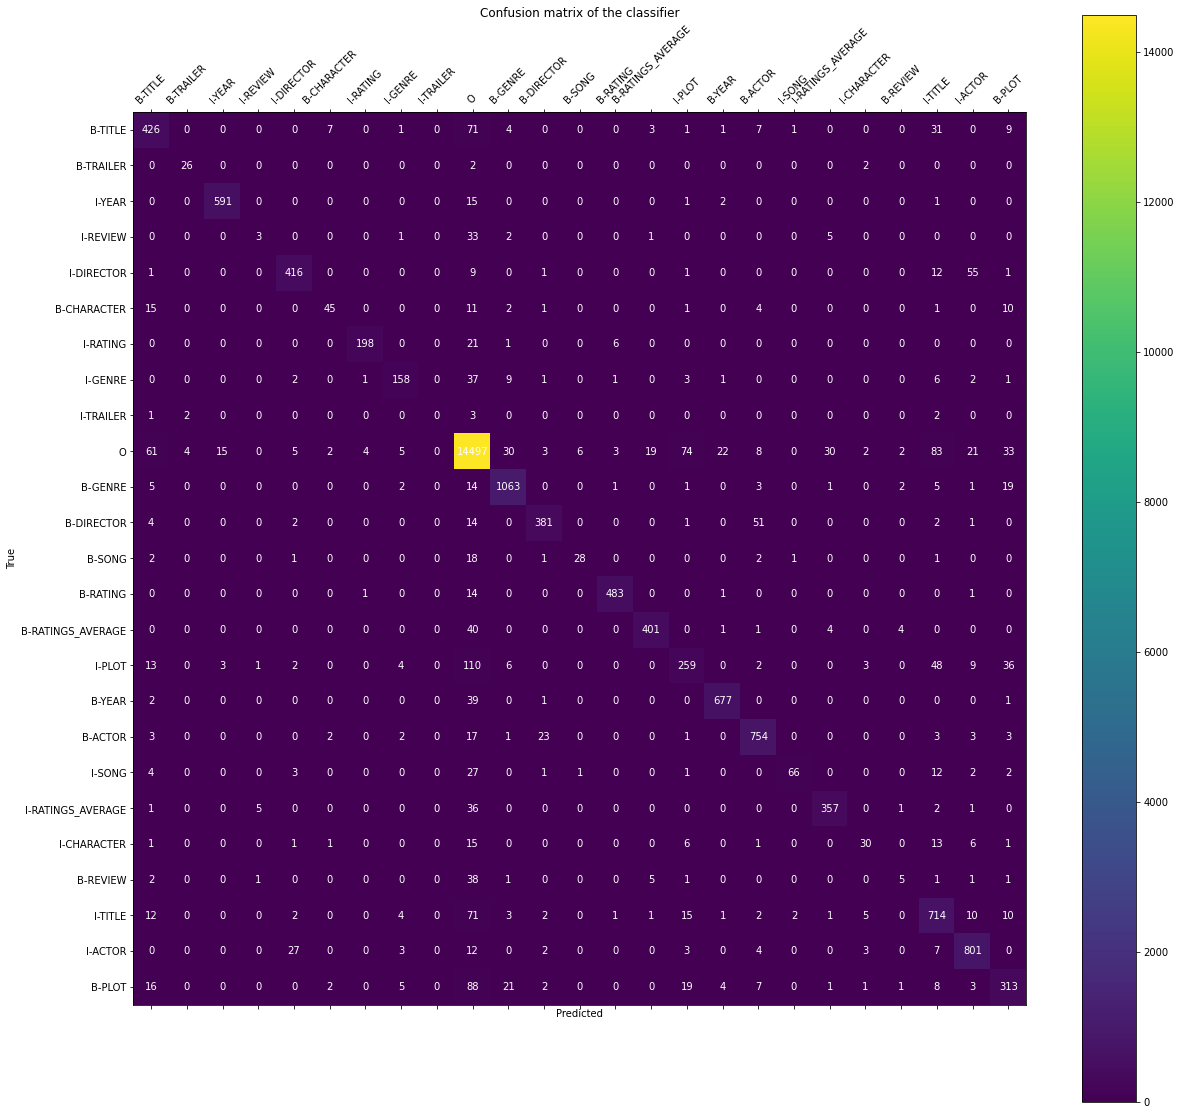

In [50]:
confusion_matrix_heatmap(y_test, preds)

# SUMMARY

In [48]:
print('\n')
print("------------------THE CLASSIFICATION REPORT - TRAINING DATA SET(80/20 SPLIT)----------------")
print('\n')
print(dev_data_only)
print('\n')
print("------------------THE CLASSIFICATION REPORT - TRAINING DATA SET(80/20 SPLIT) - POS TAGGING AS FEATURE----------------")
print('\n')
print(suf_pos_only)
print('\n')
print("------------------THE CLASSIFICATION REPORT - TRAINING DATA SET(80/20 SPLIT) - NEXT WORD AS FEATURE----------------")
print('\n')
print(nextword_only)
print('\n')
print("------------------THE CLASSIFICATION REPORT - TRAINING DATA SET(80/20 SPLIT) - NEXT AND PREVIOUS WORD AS FEATURE----------------")
print('\n')
print(allwords_only)
print('\n')
print("------------------THE CLASSIFICATION REPORT - TRAINING DATA SET(80/20 SPLIT) - PREVIOUS TAG AS FEATURE----------------")
print('\n')
print(prev_tags_only)
print('\n')
print("------------------THE CLASSIFICATION REPORT - TRAINING DATA SET(80/20 SPLIT) - NEXT AND PREVIOUS WORD AND TAG AS FEATURE---------------")
print('\n')
print(words_tags)
print('\n')
print("------------------THE CLASSIFICATION REPORT - TRAINING DATA SET AND THE TEST DATASET - AFTER ALL THE FEATURES EXPLORED ----------------")
print('\n')
print(final)



------------------THE CLASSIFICATION REPORT - TRAINING DATA SET(80/20 SPLIT)----------------


                   precision    recall  f1-score   support

          B-ACTOR       0.93      0.97      0.95       433
      B-CHARACTER       0.95      0.93      0.94        44
       B-DIRECTOR       0.95      0.91      0.93       365
          B-GENRE       0.98      0.99      0.99       927
           B-PLOT       0.93      0.87      0.90       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.93      0.90      0.91       451
         B-REVIEW       0.50      0.10      0.16        31
           B-SONG       0.72      0.65      0.68        20
          B-TITLE       0.93      0.82      0.87       679
        B-TRAILER       1.00      0.71      0.83        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.93      0.96      0.94       482
      I-CHARACTER       0.94      0.94      0.94        47
       I-DIRECTOR

| macro avg - F SCORE     |       |                  
|:-|:-|
|   INTIALLY              | 0.83  |  
|   POS TAGGING AS FEATURE|  0.64 |
|   NEXT WORD AS FEATURE              | 0.64  |  
|   NEXT AND PREVIOUS WORD AS FEATURE              | 0.70  |
|   PREVIOUS TAG AS FEATURE     | 0.64 | 
|   NEXT AND PREVIOUS WORD AND TAG AS FEATURE    | 0.71 | 
|   AFTER ALL THE FEATURES EXPLORED| 0.73 | 